In [1]:
import keras
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=10

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Cotton",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 2400 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['Aphids',
 'Army worm',
 'Bacterial Blight',
 'Healthy',
 'Powdery Mildew',
 'Target spot']

In [5]:
len(dataset)

75

In [6]:
75*32

2400

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 4 1 1 5 0 1 4 3 4 2 3 4 4 1 1 0 4 0 0 2 4 5 0 0 3 2 2 0 2 0]


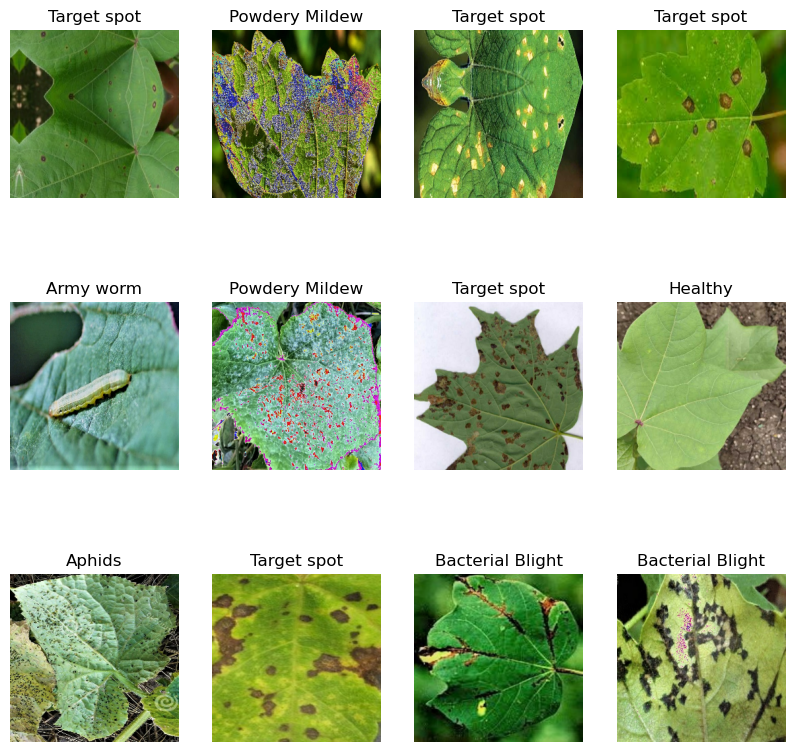

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

60.0

In [10]:
train_ds = dataset.take(60)
len(train_ds)

60

In [11]:
test_ds = dataset.skip(60)
len(test_ds)

15

In [12]:
val_size=0.1
len(dataset)*val_size

7.5

In [13]:
val_ds = test_ds.take(7)
len(val_ds)

7

In [14]:
test_ds = test_ds.skip(7)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

60

In [18]:
len(val_ds)

7

In [19]:
len(test_ds)

8

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
60/60 [==============================] - 158s 2s/step - loss: 1.7104 - accuracy: 0.2417 - val_loss: 1.7190 - val_accuracy: 0.2009
Epoch 2/10
60/60 [==============================] - 135s 2s/step - loss: 1.4774 - accuracy: 0.4130 - val_loss: 1.7431 - val_accuracy: 0.3795
Epoch 3/10
60/60 [==============================] - 134s 2s/step - loss: 1.2884 - accuracy: 0.5063 - val_loss: 1.0886 - val_accuracy: 0.5491
Epoch 4/10
60/60 [==============================] - 137s 2s/step - loss: 1.0585 - accuracy: 0.5974 - val_loss: 0.9465 - val_accuracy: 0.6429
Epoch 5/10
60/60 [==============================] - 148s 2s/step - loss: 0.9425 - accuracy: 0.6458 - val_loss: 1.3343 - val_accuracy: 0.5000
Epoch 6/10
60/60 [==============================] - 137s 2s/step - loss: 0.8889 - accuracy: 0.6661 - val_loss: 0.9024 - val_accuracy: 0.6071
Epoch 7/10
60/60 [==============================] - 134s 2s/step - loss: 0.7931 - accuracy: 0.6984 - val_loss: 0.7088 - val_accuracy: 0.7143
Epoch 8/10
60

In [28]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 16s 660ms/step - loss: 0.7494 - accuracy: 0.7188


In [29]:
scores

[0.7494389414787292, 0.71875]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 60}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

10

In [35]:
history.history['loss'][:5]

[1.7103701829910278,
 1.4773582220077515,
 1.2884248495101929,
 1.0584837198257446,
 0.9424936771392822]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

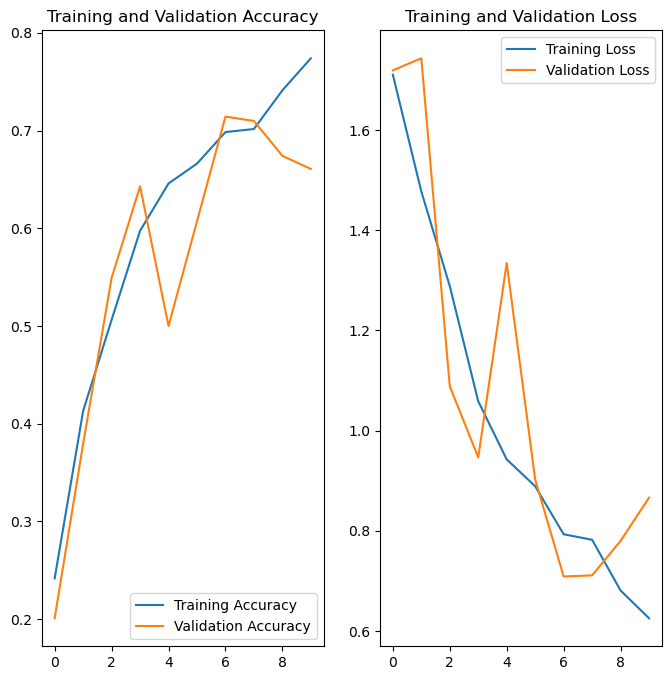

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Bacterial Blight
1/1 [==============================] - 1s 1s/step
predicted label: Bacterial Blight


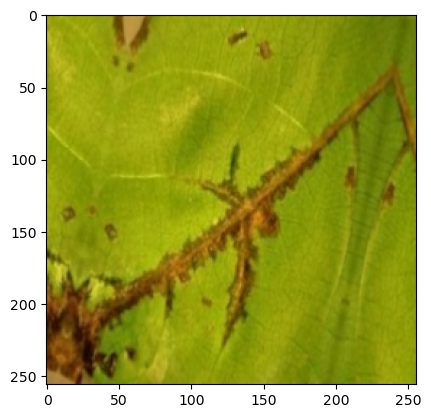

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 56ms/step


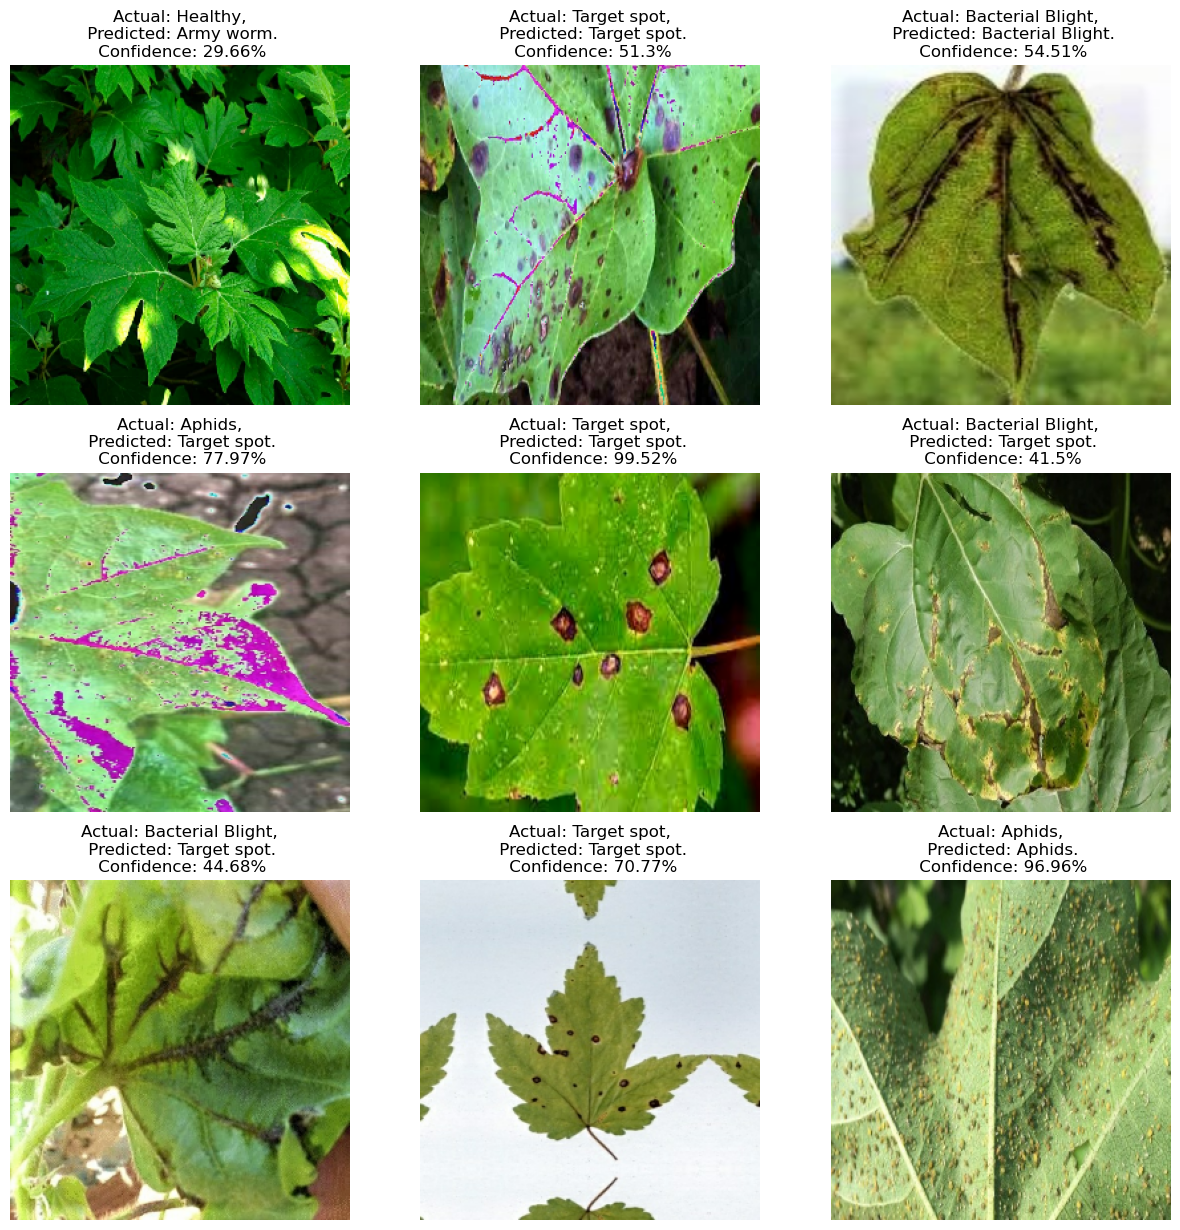

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
from keras.models import load_model
model.save('cotton.h5')

In [42]:
from keras.models import load_model
model.save_weights('cotton_weights.h5')

In [4]:
import tensorflow as tf
from tensorflow import lite
from tensorflow.keras.models import load_model
tflite_model = tf.keras.models.load_model('cotton.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model) 
tfmodel_save = converter.convert()
open("cotton.tflite", "wb").write(tfmodel_save)

INFO:tensorflow:Assets written to: C:\Users\rusha\AppData\Local\Temp\tmpls_yc9x3\assets


INFO:tensorflow:Assets written to: C:\Users\rusha\AppData\Local\Temp\tmpls_yc9x3\assets


742604